How to use this code:

If you need to change the number of neurons, you can just go to function initialize_parameters() and make sure the dimensions are compatible.

If you need to change the number of layers, you have to modify initialize_parameters(), compute_cost(), and regulizer()

Hyperparameter tunning can be achieced in function model(), where the default setting is learning_rate = 0.0001, lamb = 0.01, num_epochs = 500, minibatch_size = 512, keep_prob = 1)
the X_train, Y_train, X_test, Y_test requires the second dimension to be number of examples. Therefore, X_train.shape = [n_x, m], Y_train.shape = [1, m], X_test.shape = [n_x, m_test], Y_test.shape = [1, m_test]

In [124]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy.io
import sklearn
import sklearn.datasets

from tensorflow.python.framework import ops
%matplotlib inline

In [102]:
def random_mini_batches(X, Y, mini_batch_size = 512):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1) *mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1) *mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches:m]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches:m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


# In[39]:


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


In [221]:

#create place_holder
def create_placeholder(n_x,n_y):
    X = tf.placeholder(shape=[n_x,None],dtype = tf.float32)
    Y = tf.placeholder(shape=[n_y,None],dtype = tf.float32)
    return X,Y


# In[41]:


#initialize parameter
def initialize_parameters():
    
    W1 = tf.get_variable("W1", [100,4], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [100,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [50, 100], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [50, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 50], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [2, 1], initializer = tf.zeros_initializer())

    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters


# In[42]:


#Forward Propogation
def forward_propagation(X, parameters, keep_prob = 1):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)                                               
    A1 = tf.nn.dropout(tf.nn.relu(Z1), keep_prob)                                              
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                             
    A2 = tf.nn.dropout(tf.nn.relu(Z2), keep_prob)                                             
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3


# In[43]:


#compute cost
def compute_cost(Z3,Y):
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

def regulizer(parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    return tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)


In [222]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, lamb = 0.01,
          num_epochs = 500, minibatch_size = 512, keep_prob = 1, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                         # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = [] 
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholder(n_x, n_y)
   
    # Initialize parameters
    parameters = initialize_parameters()
    
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y) + lamb * regulizer(parameters)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [1]:
#read your data in, remeber to use one_hot_encoding for your Y, otherwise TF will not work
#Y_train = convert_to_one_hot(Y_train, 2)
#Y_test = convert_to_one_hot(Y_test, 2)



Cost after epoch 0: 1.030925
Cost after epoch 100: 0.416008
Cost after epoch 200: 0.415561
Cost after epoch 300: 0.415506
Cost after epoch 400: 0.415475


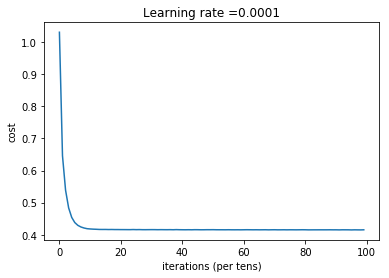

Parameters have been trained!
Train Accuracy: 0.83682
Test Accuracy: 0.834971


In [225]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [226]:
def my_relu(x):
    return x * (x > 0)

def my_softmax(x):
    result = np.zeros((x.shape[0], x.shape[1]))
    for i in range(x.shape[1]):
        result[0,i] = np.exp(x[0,i])/(np.exp(x[0,i]) + np.exp(x[1,i]))
        result[1,i] = np.exp(x[1,i])/(np.exp(x[0,i]) + np.exp(x[1,i]))
    return result
        

def get_probability(parameters, X):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    b1 = parameters['b1']
    b2 = parameters['b2']
    b3 = parameters['b3']
    A1 = my_relu(np.dot(W1, X) + b1)
    A2 = my_relu(np.dot(W2, A1) + b2)
    A3 = my_softmax(np.dot(W3, A2) + b3)
    return A3

In [227]:
default_prob = get_probability(parameters, X_test)[1,:]

In [228]:
def get_ROC(default_prob,t,Y_test):#default if 1
    TP = 0.0
    FP = 0.0
    FN = 0.0
    TN = 0.0
    for i in range(default_prob.shape[0]):
        if default_prob[i] > t:#default
            if abs(Y_test[i] - 1.0) < 0.01:
                TP += 1
            else:
                FP += 1
        else:
            if abs(Y_test[i] - 1.0) < 0.01:
                FN += 1
            else:
                TN += 1
    return TP/(TP+FN), FP/(FP+TN)
    #return TP,FN,FP,TN

In [229]:
n = 200
TPR = np.zeros((n,1))
FPR = np.zeros((n,1))
t = np.linspace(0.0, 1.0, n)
for i in range(n):
    TPR[i,0], FPR[i,0] = get_ROC(default_prob,t[i],Y_test[1,:])

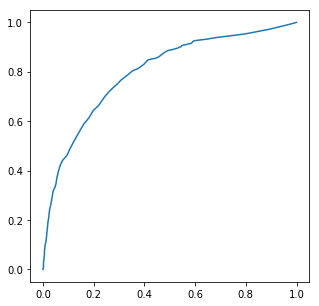

In [230]:
plt.figure(figsize=(5,5))
plt.plot(FPR, TPR)